In [1]:
# Chose a value between 1 and 4
TrainingChoice = 2

# Install the libraries below
#pip install pandas
#pip install matplotlib
#pip install numpy
#pip install tensorflow
#pip install scikit-learn
#pip install keras-tuner

**Import the libraries**

In [2]:
# General purpouses libraries
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import os

# AI libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

print("The libraries were imported.")

2024-10-02 00:07:49.404070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 00:07:49.409693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 00:07:49.479236: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 00:07:49.575306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 00:07:49.636028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

The libraries were imported.


/tmp/ipykernel_1172461/3764652187.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


**Define that the code will be executed on the GPU if it's possible**

In [3]:
# List all the avaliable GPUs
gpus = tf.config.list_physical_devices('GPU')

# Intends to use the GPU instead of the CPU, if it's possible
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Using CPU instead.")
    tf.config.set_visible_devices([], 'GPU')

I0000 00:00:1727838474.340335 1172461 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-02 00:07:54.341339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


No GPU detected. Using CPU instead.


**Import the database**

In [4]:
# Define and import the database
path = "./BaseDeDadosValoresCorrigidosV2.csv"
Database = pd.read_csv(path, delimiter=',', decimal='.', dayfirst=True)
print("The database was imported")

The database was imported


In [5]:
display(Database)

,Precipitacao horario total (mm),Pressao atmosferica horaria ao nivel da estacao (mB),Pressao atmosferica maxima na hora anterior (mB),Pressao atmosferica minima na hora anterior (mB),Radiacao global (KJ/m2),Temperatura do ar (C),Temperatura do ponto de orvalho (C),Temperatura maxima hora anterior (C),Temperatura minima hora anterior (C),Temperatura do ponto de orvalho maximo hora anterior (C),Temperatura do ponto de orvalho minima hora anterior (C),Umidade relativa do ar maxima hora anteior(%),Umidade relativa do ar minima hora anterior (%),Umidade relativa do ar (%),Data (Segundos),VentoX,VentoY,VentoRajadaX,VentoRajadaY
0,0.0,874.1,874.5,874.0,1006.0,24.0,15.0,25.0,23.2,16.6,14.8,62.0,56.0,57.0,1.164931e+09,-0.612234,-0.339367,-4.460561,-2.472529
1,0.0,874.1,874.5,874.0,1006.0,24.0,15.0,25.0,23.2,16.6,14.8,62.0,56.0,57.0,1.164935e+09,-0.612234,-0.339367,-4.460561,-2.472529
2,0.0,874.1,874.5,874.0,1006.0,24.0,15.0,25.0,23.2,16.6,14.8,62.0,56.0,57.0,1.164938e+09,-0.612234,-0.339367,-4.460561,-2.472529
3,0.0,874.1,874.5,874.0,1006.0,24.0,15.0,25.0,23.2,16.6,14.8,62.0,56.0,57.0,1.164942e+09,-0.612234,-0.339367,-4.460561,-2.472529
4,0.0,874.1,874.5,874.0,1006.0,24.0,15.0,25.0,23.2,16.6,14.8,62.0,56.0,57.0,1.164946e+09,-0.612234,-0.339367,-4.460561,-2.472529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140995,0.0,875.1,875.5,875.0,840.1,23.7,17.3,24.3,22.6,18.6,16.7,74.0,63.0,68.0,1.672513e+09,-0.996195,-0.087156,-4.383257,-0.383485
140996,0.0,874.7,875.1,874.6,1221.2,24.0,18.1,24.2,22.7,18.1,16.7,72.0,65.0,69.0,1.672517e+09,-0.706358,0.375577,-3.884969,2.065675
140997,0.0,875.4,875.5,874.7,392.1,20.2,16.3,24.2,20.2,18.4,15.9,79.0,67.0,79.0,1.672520e+09,0.208378,1.181769,1.250267,7.090616
140998,0.0,875.7,875.7,875.1,26.6,18.8,15.6,20.2,18.3,16.0,15.0,86.0,75.0,81.0,1.672524e+09,-0.000000,-0.000000,-3.896477,-2.628207


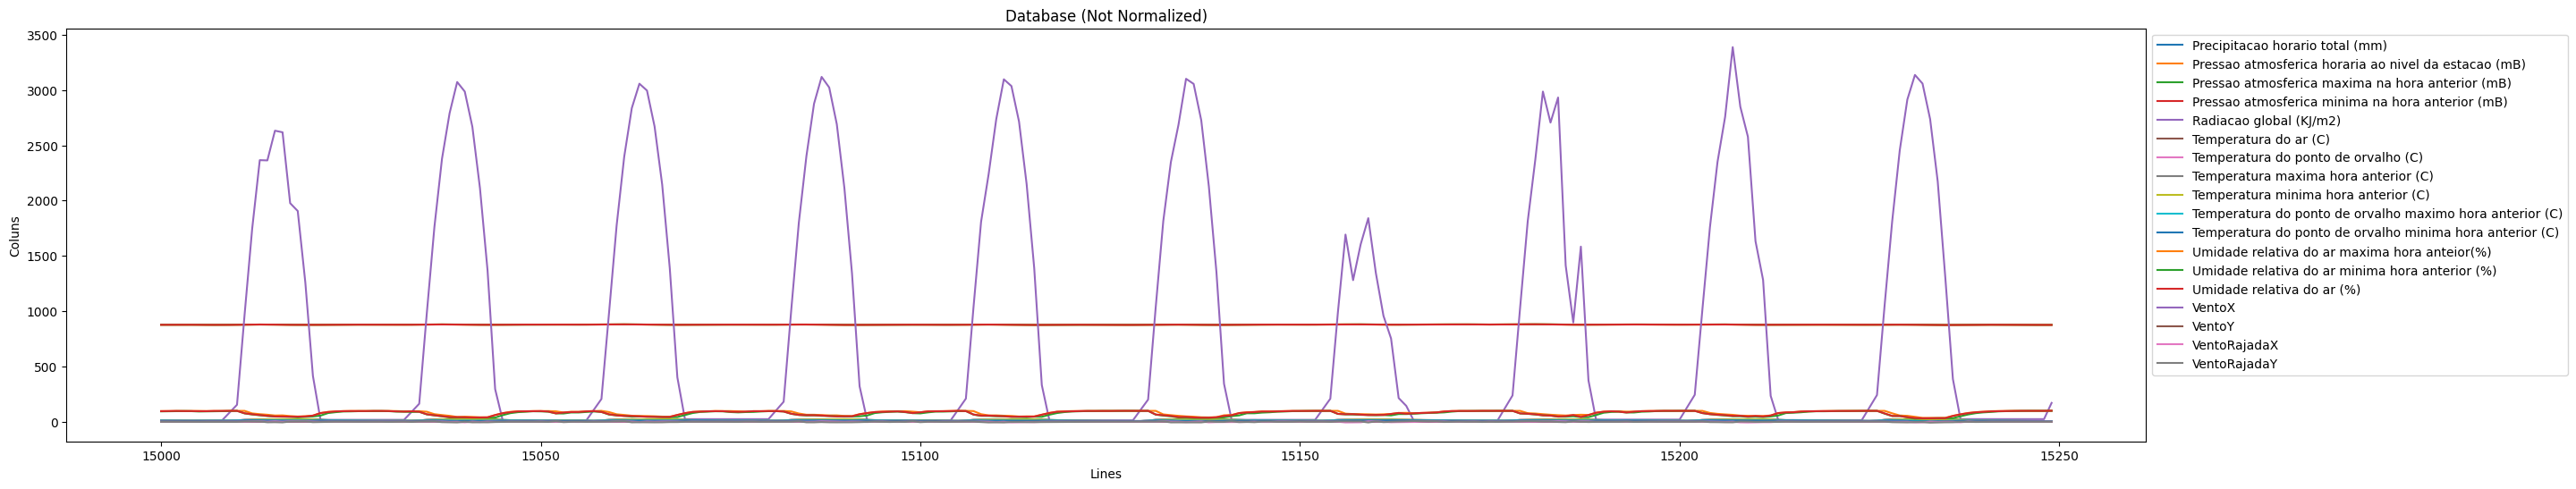

In [6]:
# Show the database graphic
Coluns = ["Precipitacao horario total (mm)","Pressao atmosferica horaria ao nivel da estacao (mB)","Pressao atmosferica maxima na hora anterior (mB)","Pressao atmosferica minima na hora anterior (mB)","Radiacao global (KJ/m2)","Temperatura do ar (C)","Temperatura do ponto de orvalho (C)","Temperatura maxima hora anterior (C)","Temperatura minima hora anterior (C)","Temperatura do ponto de orvalho maximo hora anterior (C)","Temperatura do ponto de orvalho minima hora anterior (C)","Umidade relativa do ar maxima hora anteior(%)","Umidade relativa do ar minima hora anterior (%)","Umidade relativa do ar (%)","VentoX","VentoY","VentoRajadaX","VentoRajadaY"]

# Size of the graphic (Width = 30 and Height = 6)
plt.figure(figsize=(30, 6))

StartLine = 15000
EndLine = 15250

for Colum in Coluns:
  plt.plot(Database.index[StartLine:EndLine], Database[Colum][StartLine:EndLine], label=Colum)

# Labels
plt.xlabel('Lines')
plt.ylabel('Coluns')
# Title
plt.title('Database (Not Normalized)')
# Labels
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Save the images on Google Colab
plt.savefig('./GraficoBaseDeDadosNaoNormalizada.png')
# Show the graphic on the output of the cell
plt.show()

**Normalize the database**

In [7]:
# Coluns that will be normalized
Coluns = ["Precipitacao horario total (mm)","Pressao atmosferica horaria ao nivel da estacao (mB)","Pressao atmosferica maxima na hora anterior (mB)","Pressao atmosferica minima na hora anterior (mB)","Radiacao global (KJ/m2)","Temperatura do ar (C)","Temperatura do ponto de orvalho (C)","Temperatura maxima hora anterior (C)","Temperatura minima hora anterior (C)","Temperatura do ponto de orvalho maximo hora anterior (C)","Temperatura do ponto de orvalho minima hora anterior (C)","Umidade relativa do ar maxima hora anteior(%)","Umidade relativa do ar minima hora anterior (%)","Umidade relativa do ar (%)","Data (Segundos)","VentoX","VentoY","VentoRajadaX","VentoRajadaY"]

# Normalize these coluns
scaler = StandardScaler()
Database[Coluns] = scaler.fit_transform(Database[Coluns])

# Save the database on Google Colab as a CSV file
Database.to_csv('./BaseDeDadosNormalizada.csv', index=False)

In [8]:
display(Database)

,Precipitacao horario total (mm),Pressao atmosferica horaria ao nivel da estacao (mB),Pressao atmosferica maxima na hora anterior (mB),Pressao atmosferica minima na hora anterior (mB),Radiacao global (KJ/m2),Temperatura do ar (C),Temperatura do ponto de orvalho (C),Temperatura maxima hora anterior (C),Temperatura minima hora anterior (C),Temperatura do ponto de orvalho maximo hora anterior (C),Temperatura do ponto de orvalho minima hora anterior (C),Umidade relativa do ar maxima hora anteior(%),Umidade relativa do ar minima hora anterior (%),Umidade relativa do ar (%),Data (Segundos),VentoX,VentoY,VentoRajadaX,VentoRajadaY
0,-0.146608,-0.726976,-0.671154,-0.683093,0.299345,1.380937,0.500222,1.397644,1.396290,0.741168,0.605061,-1.424558,-1.157659,-1.383263,-1.732039,-1.108632,-0.512054,-2.072663,-0.988843
1,-0.146608,-0.726976,-0.671154,-0.683093,0.299345,1.380937,0.500222,1.397644,1.396290,0.741168,0.605061,-1.424558,-1.157659,-1.383263,-1.732014,-1.108632,-0.512054,-2.072663,-0.988843
2,-0.146608,-0.726976,-0.671154,-0.683093,0.299345,1.380937,0.500222,1.397644,1.396290,0.741168,0.605061,-1.424558,-1.157659,-1.383263,-1.731989,-1.108632,-0.512054,-2.072663,-0.988843
3,-0.146608,-0.726976,-0.671154,-0.683093,0.299345,1.380937,0.500222,1.397644,1.396290,0.741168,0.605061,-1.424558,-1.157659,-1.383263,-1.731965,-1.108632,-0.512054,-2.072663,-0.988843
4,-0.146608,-0.726976,-0.671154,-0.683093,0.299345,1.380937,0.500222,1.397644,1.396290,0.741168,0.605061,-1.424558,-1.157659,-1.383263,-1.731940,-1.108632,-0.512054,-2.072663,-0.988843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140995,-0.146608,-0.388512,-0.330298,-0.345786,0.133807,1.324120,1.097042,1.266628,1.280648,1.270431,1.087592,-0.681395,-0.797796,-0.771416,1.731940,-1.689792,-0.202532,-2.039949,-0.218498
140996,-0.146608,-0.523898,-0.466641,-0.480709,0.514077,1.380937,1.304631,1.247912,1.299922,1.138115,1.087592,-0.805255,-0.694978,-0.715794,1.731965,-1.251098,0.365350,-1.829077,0.684641
140997,-0.146608,-0.286973,-0.330298,-0.446978,-0.313217,0.661249,0.837555,1.247912,0.818077,1.217504,0.884421,-0.371744,-0.592161,-0.159569,1.731989,0.133440,1.354736,0.344119,2.537613
140998,-0.146608,-0.185433,-0.262127,-0.312055,-0.677921,0.396100,0.655914,0.499249,0.451875,0.582389,0.655853,0.061767,-0.180889,-0.048324,1.732014,-0.181959,-0.095572,-1.833947,-1.046250


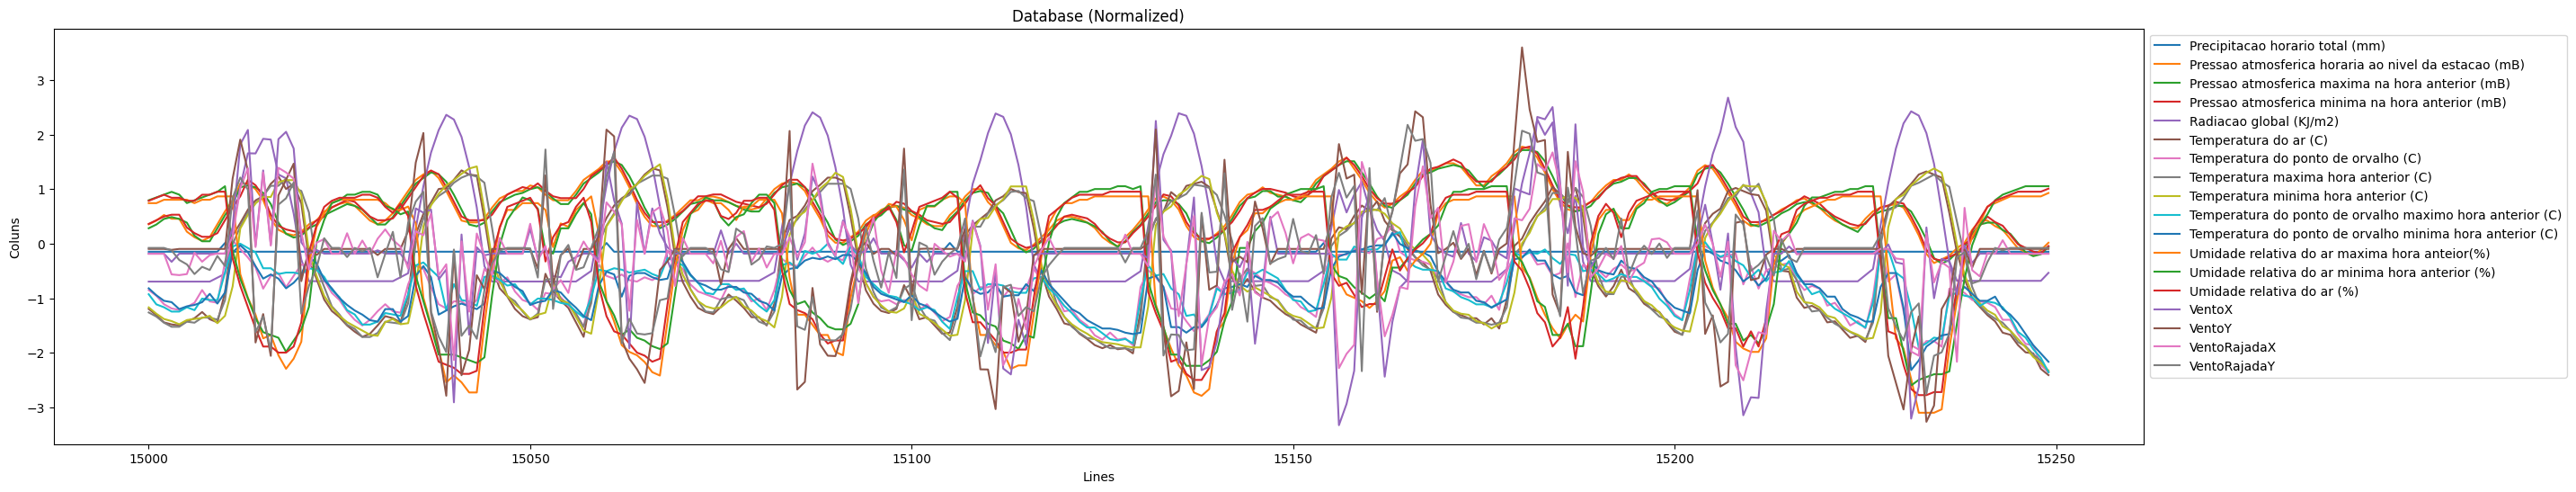

In [9]:
# Show the last database grpahic, but now it's normalized
Coluns = ["Precipitacao horario total (mm)","Pressao atmosferica horaria ao nivel da estacao (mB)","Pressao atmosferica maxima na hora anterior (mB)","Pressao atmosferica minima na hora anterior (mB)","Radiacao global (KJ/m2)","Temperatura do ar (C)","Temperatura do ponto de orvalho (C)","Temperatura maxima hora anterior (C)","Temperatura minima hora anterior (C)","Temperatura do ponto de orvalho maximo hora anterior (C)","Temperatura do ponto de orvalho minima hora anterior (C)","Umidade relativa do ar maxima hora anteior(%)","Umidade relativa do ar minima hora anterior (%)","Umidade relativa do ar (%)","VentoX","VentoY","VentoRajadaX","VentoRajadaY"]

plt.figure(figsize=(30, 6))

StartLine = 15000
EndLine = 15250

for Colum in Coluns:
  plt.plot(Database.index[StartLine:EndLine], Database[Colum][StartLine:EndLine], label=Colum)

plt.xlabel('Lines')
plt.ylabel('Coluns')

plt.title('Database (Normalized)')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('./GraficoBaseDeDadosNormalizada.png')

plt.show()

**Data windowing**

In [10]:
if TrainingChoice == 1 or TrainingChoice == 2:
    InputWindowSize = 168
    OutputWindowSize = 24
    GapSize = 24
elif TrainingChoice == 3 or TrainingChoice == 4:
    InputWindowSize = 168
    OutputWindowSize = 72
    GapSize = 24

# Function that create the windows that will be used on the model
def InputOutputSeparator(Data, InputWindowSize, OutputWindowSize, GapSize):
    Input, Output = [], []
    for i in range(0, len(Data) - InputWindowSize - OutputWindowSize + 1, GapSize):
        Input.append(Data[i:(i + InputWindowSize)])
        Output.append(Data[(i + InputWindowSize):(i + InputWindowSize + OutputWindowSize)])
    return np.array(Input), np.array(Output)

Coluns = ["Precipitacao horario total (mm)","Pressao atmosferica horaria ao nivel da estacao (mB)","Pressao atmosferica maxima na hora anterior (mB)","Pressao atmosferica minima na hora anterior (mB)","Radiacao global (KJ/m2)","Temperatura do ar (C)","Temperatura do ponto de orvalho (C)","Temperatura maxima hora anterior (C)","Temperatura minima hora anterior (C)","Temperatura do ponto de orvalho maximo hora anterior (C)","Temperatura do ponto de orvalho minima hora anterior (C)","Umidade relativa do ar maxima hora anteior(%)","Umidade relativa do ar minima hora anterior (%)","Umidade relativa do ar (%)","Data (Segundos)","VentoX","VentoY","VentoRajadaX","VentoRajadaY"]

# Convert the database to a Numpy array
Data = Database[Coluns].values

# Create the sets of inputs-ouputs
Input, Output = InputOutputSeparator(Data, InputWindowSize, OutputWindowSize, GapSize)
# Define the number of Features of the codes (Number of diferent parameters that are going to be predicted)
num_features = len(Coluns)

In [11]:
# Show the dimension of the inputs and outputs
print("Input shape:", Input.shape)
print("Output shape:", Output.shape)

Input shape: (5868, 168, 19)
Output shape: (5868, 24, 19)


In [12]:
# Show some of the windows of Input-Outputs
for i in range(min(5, len(Input))):
  print("Window", i+1, ":")
  print("Input:", Input[i])
  print("Output:", Output[i])
  print()

Window 1 :
Input: [[-0.14660827 -0.72697637 -0.67115414 ... -0.51205443 -2.07266316
  -0.98884314]
 [-0.14660827 -0.72697637 -0.67115414 ... -0.51205443 -2.07266316
  -0.98884314]
 [-0.14660827 -0.72697637 -0.67115414 ... -0.51205443 -2.07266316
  -0.98884314]
 ...
 [-0.14660827 -2.31775872 -2.40951968 ... -1.46809359 -2.1847897
  -1.25245507]
 [-0.14660827 -2.04698726 -2.13683489 ...  0.20781725 -2.35837967
   0.53825196]
 [-0.14660827 -1.91160153 -1.9323213  ... -0.06987391 -1.45379078
  -0.03847809]]
Output: [[-1.46608275e-01 -1.60698363e+00 -1.69372211e+00 -1.82993693e+00
  -6.69239981e-01 -2.09952950e-01  2.66683476e-01  1.06200442e-01
  -8.77909273e-02  2.64831463e-01  3.76493135e-01  4.33348736e-01
   7.61557900e-02  5.07901138e-01 -1.72791108e+00 -8.01890511e-01
  -4.47528254e-01 -1.01696775e+00 -5.84707925e-01]
 [-1.46608275e-01 -1.33621217e+00 -1.42103732e+00 -1.52636060e+00
  -6.69239981e-01 -3.61466282e-01  2.40734782e-01 -3.42997389e-01
  -3.19076343e-01  1.58978905e-01  2

**Separate the data in train, test and validation**

In [13]:
# Separate the data (70% for Training, 15% for Testing and 15% for Validation)
InputTraining, InputTemporary, OutputTraining, OutputTemporary = train_test_split(Input, Output, test_size=0.3, random_state=0)
InputValidation, InputTest, OutputValidation, OutputTest = train_test_split(InputTemporary, OutputTemporary, test_size=0.5, random_state=0)

# Convert the values to float32
InputTraining= InputTraining.astype('float32')
OutputTraining = OutputTraining.astype('float32')
InputTest= InputTest.astype('float32')
Saidas_teste = OutputTest.astype('float32')
InputValidation= InputValidation.astype('float32')
OutputValidation = OutputValidation.astype('float32')

**Checkpoints and EarlyStopping**


In [14]:
checkpoint_path = "./model_checkpoint.keras"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, save_freq=10)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

**Choose or build a model**

In [15]:
Choice = 0

if Choice == 0:
    # Create a new model with Keras Tuner
    def BuildModel(hp):
        model = Sequential()

        # Model hiperparameters
        lstm_units = hp.Int('units', min_value=16, max_value=512, step=32)
        dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.75, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=5e-2, sampling='LOG')
        l1_regularization = hp.Float('l1', min_value=1e-5, max_value=5e-2, sampling='LOG')

        # Model architecture
        model.add(LSTM(lstm_units, input_shape=(InputWindowSize, num_features), return_sequences=False, kernel_regularizer=l1(l1_regularization)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(24 * 19))
        model.add(Reshape((24, 19)))

        if TrainingChoice == 1 or TrainingChoice == 3:
            # Compile the model
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif TrainingChoice == 2 or TrainingChoice == 4:
            # Compile the model
            optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
        
        #optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

        return model

    # Set the Tuner
    tuner = RandomSearch(
        BuildModel,
        objective='val_loss',
        overwrite = True,
        seed = 55,
        max_trials=15,
        executions_per_trial=3,
        directory='./Modelos',
        project_name='LSTM_hyperparameter_tuning'
    )

    # Use the tunner
    tuner.search(InputTraining, OutputTraining, epochs=100, batch_size=1024, validation_data=(InputValidation, OutputValidation))

    # Find the best hiperparameters
    BestHps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(BestHps.values)

    # Build the model
    model = tuner.hypermodel.build(BestHps)

elif Choice == 1:
    # Load a model
    save_path = "./ModeloClimaIA.keras"
    model = load_model(save_path)

elif Choice == 2:
    # Load a checkpoint model
    model = load_model(checkpoint_path)

Trial 3 Complete [00h 22m 55s]
val_loss: 0.35083747903505963

Best val_loss So Far: 0.35083747903505963
Total elapsed time: 00h 45m 04s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
48                |240               |units
0.5               |0.3               |dropout
0.0033961         |0.00034208        |learning_rate
0.023185          |1.8278e-05        |l1

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - loss: 7.9937 - mean_absolute_error: 0.7577 - val_loss: 7.0925 - val_mean_absolute_error: 0.7255
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 6.8928 - mean_absolute_error: 0.7201 - val_loss: 5.9721 - val_mean_absolute_error: 0.6427
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - loss: 5.7753 - mean_absolute_error: 0.6400 - val_loss: 4.8629 - val_mean_absolute_error: 0.5551
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - loss: 4.6997 - mean_absolute_error: 0.5728 - val_loss: 3.8786 - val_mean_absolute_error: 0.5125
Epoc

**Show the model architecture**

In [20]:
# Show the model architecture (Text)
model.summary()

print()

# Show the model architecture (Graphic)
plot_model(model, to_file='./ArquiteturaDoModelo.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 208)            │       189,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 456)            │        95,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 24, 19)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,000 (1.09 MB)

 Trainable params: 285,000 (1.09 MB)

 Non-trainable params: 0 (0.00 B)


You must install pydot (`pip install pydot`) for `plot_model` to work.


**Training the model**

In [21]:
# Show the shape of the data that is going to be used on the training
print("InputTrainingShape:", InputTraining.shape)
print("OutputTrainingShape:", OutputTraining.shape)
print("InputTestShape:", InputTest.shape)
print("OutputTestShape:", OutputTest.shape)
print("InputValidationShape:", InputValidation.shape)
print("OutputValidationShape:", OutputValidation.shape)

InputTrainingShape: (4107, 168, 19)
OutputTrainingShape: (4107, 24, 19)
InputTestShape: (881, 168, 19)
OutputTestShape: (881, 24, 19)
InputValidationShape: (880, 168, 19)
OutputValidationShape: (880, 24, 19)


In [22]:
# Null lists that are going to be used on the training of the model
SquareErrorsTraining = []
SquareErrorsValidation = []
AbsoluteErrorsTraining = []
AbsoluteErrorsValidation = []

# Define the number of epochs and the batch size
Epochs = 2000
Batch = 1024

In [23]:
# Training the model
history = model.fit(InputTraining, OutputTraining, epochs=Epochs, batch_size=Batch, validation_data=(InputValidation, OutputValidation), verbose=1, callbacks=[checkpoint_callback,early_stopping])

SquareErrorsTraining.extend(history.history['loss'])
SquareErrorsValidation.extend(history.history['val_loss'])
AbsoluteErrorsTraining.extend(history.history['mean_absolute_error'])
AbsoluteErrorsValidation.extend(history.history['val_mean_absolute_error'])

Epoch 1/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step - loss: 1.0053 - mean_absolute_error: 0.7507 - val_loss: 0.8059 - val_mean_absolute_error: 0.6579
Epoch 2/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 745ms/step - loss: 0.7638 - mean_absolute_error: 0.6339 - val_loss: 0.6007 - val_mean_absolute_error: 0.5335
Epoch 3/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 722ms/step - loss: 0.5877 - mean_absolute_error: 0.5273 - val_loss: 0.5193 - val_mean_absolute_error: 0.4794
Epoch 4/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 701ms/step - loss: 0.5165 - mean_absolute_error: 0.4820 - val_loss: 0.4865 - val_mean_absolute_error: 0.4611
Epoch 5/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 722ms/step - loss: 0.4841 - mean_absolute_error: 0.4612 - val_loss: 0.4575 - val_mean_absolute_error: 0.4353
Epoch 6/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 718ms/step - loss: 0.4565 - mean_absolute_error: 0.4371 - val_loss: 0.4317 - val_mean_absolute_error: 0.4118
Epoch 7/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 726ms/step - loss: 0.4301 - mean_absolute_error: 0.4141 - v

**Training Results (Graphics)**

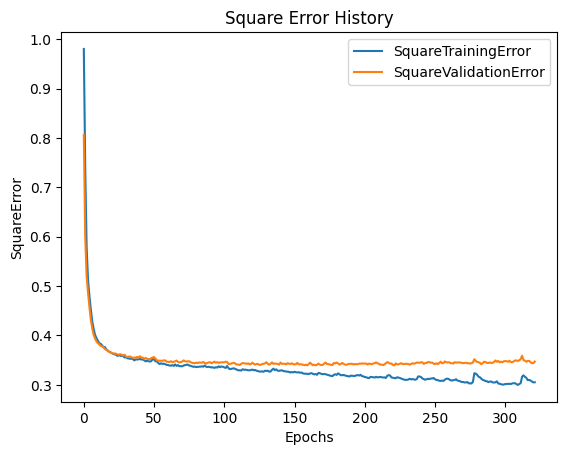

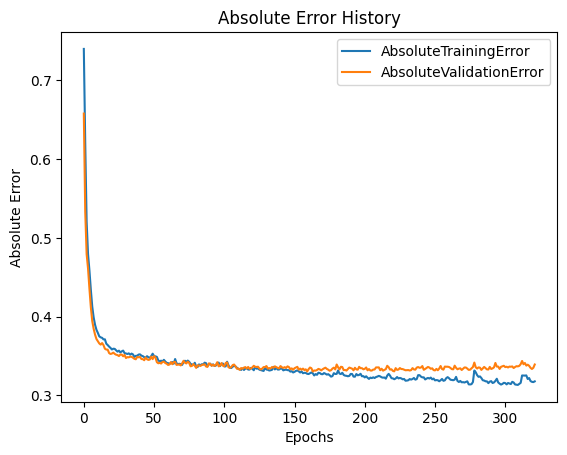

In [24]:
plt.plot(SquareErrorsTraining, label='SquareTrainingError')
plt.plot(SquareErrorsValidation, label='SquareValidationError')
plt.xlabel('Epochs')
plt.ylabel('SquareError')
plt.title('Square Error History')
plt.legend()

if TrainingChoice == 1:
    plt.savefig('./GraficoErroQuadradoAdam_1Dia.png')
elif TrainingChoice == 2:
    plt.savefig('./GraficoErroQuadradoNadam_1Dia.png')
elif TrainingChoice == 3:
    plt.savefig('./GraficoErroQuadradoAdam_3Dias.png')
elif TrainingChoice == 4:
    plt.savefig('./GraficoErroQuadradoNadam_3Dias.png')

plt.show()

print()

plt.plot(AbsoluteErrorsTraining, label='AbsoluteTrainingError')
plt.plot(AbsoluteErrorsValidation, label='AbsoluteValidationError')
plt.xlabel('Epochs')
plt.ylabel('Absolute Error')
plt.title('Absolute Error History')
plt.legend()

if TrainingChoice == 1:
    plt.savefig('./GraficoErroAbsolutoAdam_1Dia.png')
elif TrainingChoice == 2:
    plt.savefig('./GraficoErroAbsolutoNadam_1Dia.png')
elif TrainingChoice == 3:
    plt.savefig('./GraficoErroAbsolutoAdam_3Dias.png')
elif TrainingChoice == 4:
    plt.savefig('./GraficoErroAbsolutoNadam_3Dias.png')

plt.show()

**Save the trained model in Google Colab**

In [25]:
if TrainingChoice == 1:
    save_path = "./1DiaAdamIA.keras"
elif TrainingChoice == 2:
    save_path = "./1DiaNadamIA.keras"
elif TrainingChoice == 3:
    save_path = "./3DiasAdamIA.keras"
elif TrainingChoice == 4:
    save_path = "./3DiasNadamIA.keras"

model.save(save_path)
print("The model was saved.")

The model was saved.
